# Automatic Image Captioning Generator Using Efficient Techniques

## Problem Statement
The goal is to develop a deep learning-based system for automatic image captioning that is both efficient and effective. The system should be capable of generating descriptive captions for images, leveraging minimal computational resources to ensure feasibility on local devices with limited memory.

## Data Preparation & EDA
The Flickr8K dataset, a commonly used benchmark in image captioning tasks, will be employed for training and evaluating the model. This dataset comprises 8,090 images, each with five different captions, providing a comprehensive set of examples for learning.

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.decomposition import PCA
import re
import string

# Path to the Flickr8K images and captions file
dataset_path = 'D:/Users/user/flickr8k'
images_path = os.path.join(dataset_path, 'Images')
captions_path = os.path.join(dataset_path, 'captions.txt')

# Load captions and image names
def load_captions(filename):
    with open(filename, 'r') as file:
        text = file.read()
    captions_dict = {}
    for line in text.split('\n'):
        tokens = line.split(',')
        if len(line) < 2:
            continue
        image_id, caption = tokens[0], tokens[1]
        image_id = image_id.split('#')[0]
        caption = 'startseq ' + caption + ' endseq'
        if image_id not in captions_dict:
            captions_dict[image_id] = []
        captions_dict[image_id].append(caption)
    return captions_dict

# Load the captions
captions_dict = load_captions(captions_path)


In [2]:
def clean_captions(captions_dict):
    cleaned_captions = {}
    for image_id, captions in captions_dict.items():
        cleaned_captions[image_id] = []
        for caption in captions:
            # Convert to lowercase
            caption = caption.lower()
            # Remove 's, numbers, and punctuation
            caption = re.sub(r'\d+', '', caption)  # Remove numbers
            caption = caption.replace("'s", '')  # Remove 's
            caption = re.sub(r'\ba\b', '', caption)  # Remove 'a'
            caption = caption.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
            # Removing extra spaces
            caption = re.sub(r'\s+', ' ', caption).strip()
            cleaned_captions[image_id].append(caption)
    return cleaned_captions

# Clean the captions
captions_dict = clean_captions(captions_dict)
del captions_dict["image"] #deleting header

In [3]:
# Create a list of all captions
all_captions = []
for key, val in captions_dict.items():
    for cap in val:
        all_captions.append(cap)
# all_captions = all_captions[1:]
all_captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas w

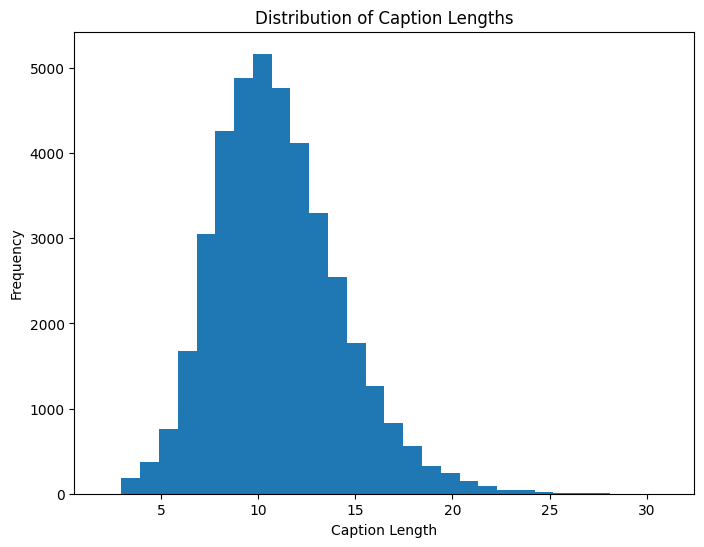

In [4]:
# Calculate caption lengths
caption_lengths = [len(caption.split()) for caption in all_captions]

# Plot the distribution of caption lengths
plt.figure(figsize=(8, 6))
plt.hist(caption_lengths, bins=30)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

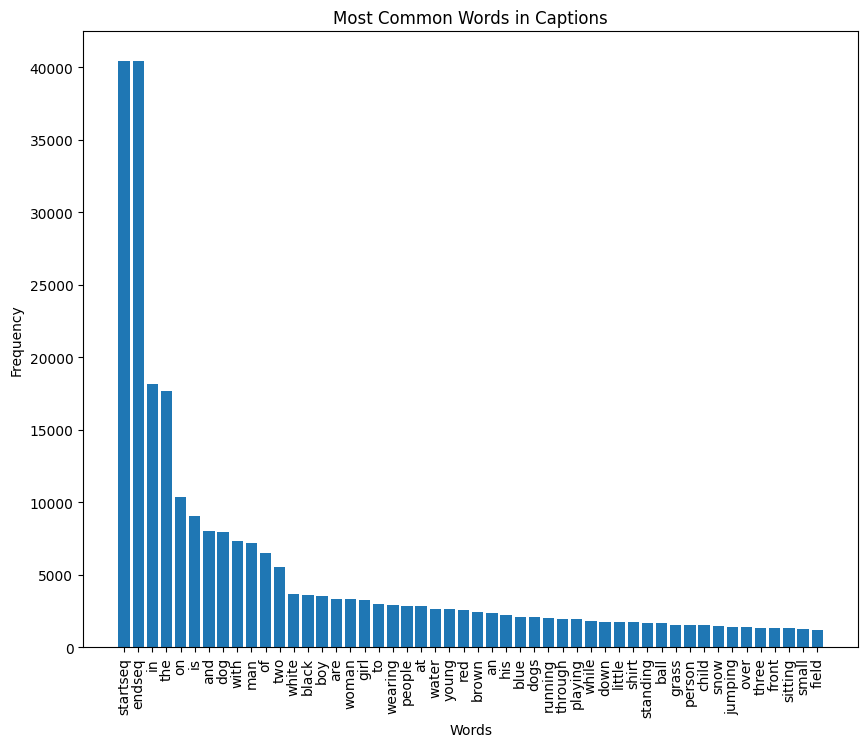

In [5]:
# Count words frequency
words_count = Counter()
for caption in all_captions:
    words_count.update(caption.split())

# Most common words
common_words = words_count.most_common(50)

# Plotting most common words
words, frequencies = zip(*common_words)
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies)
plt.title('Most Common Words in Captions')
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

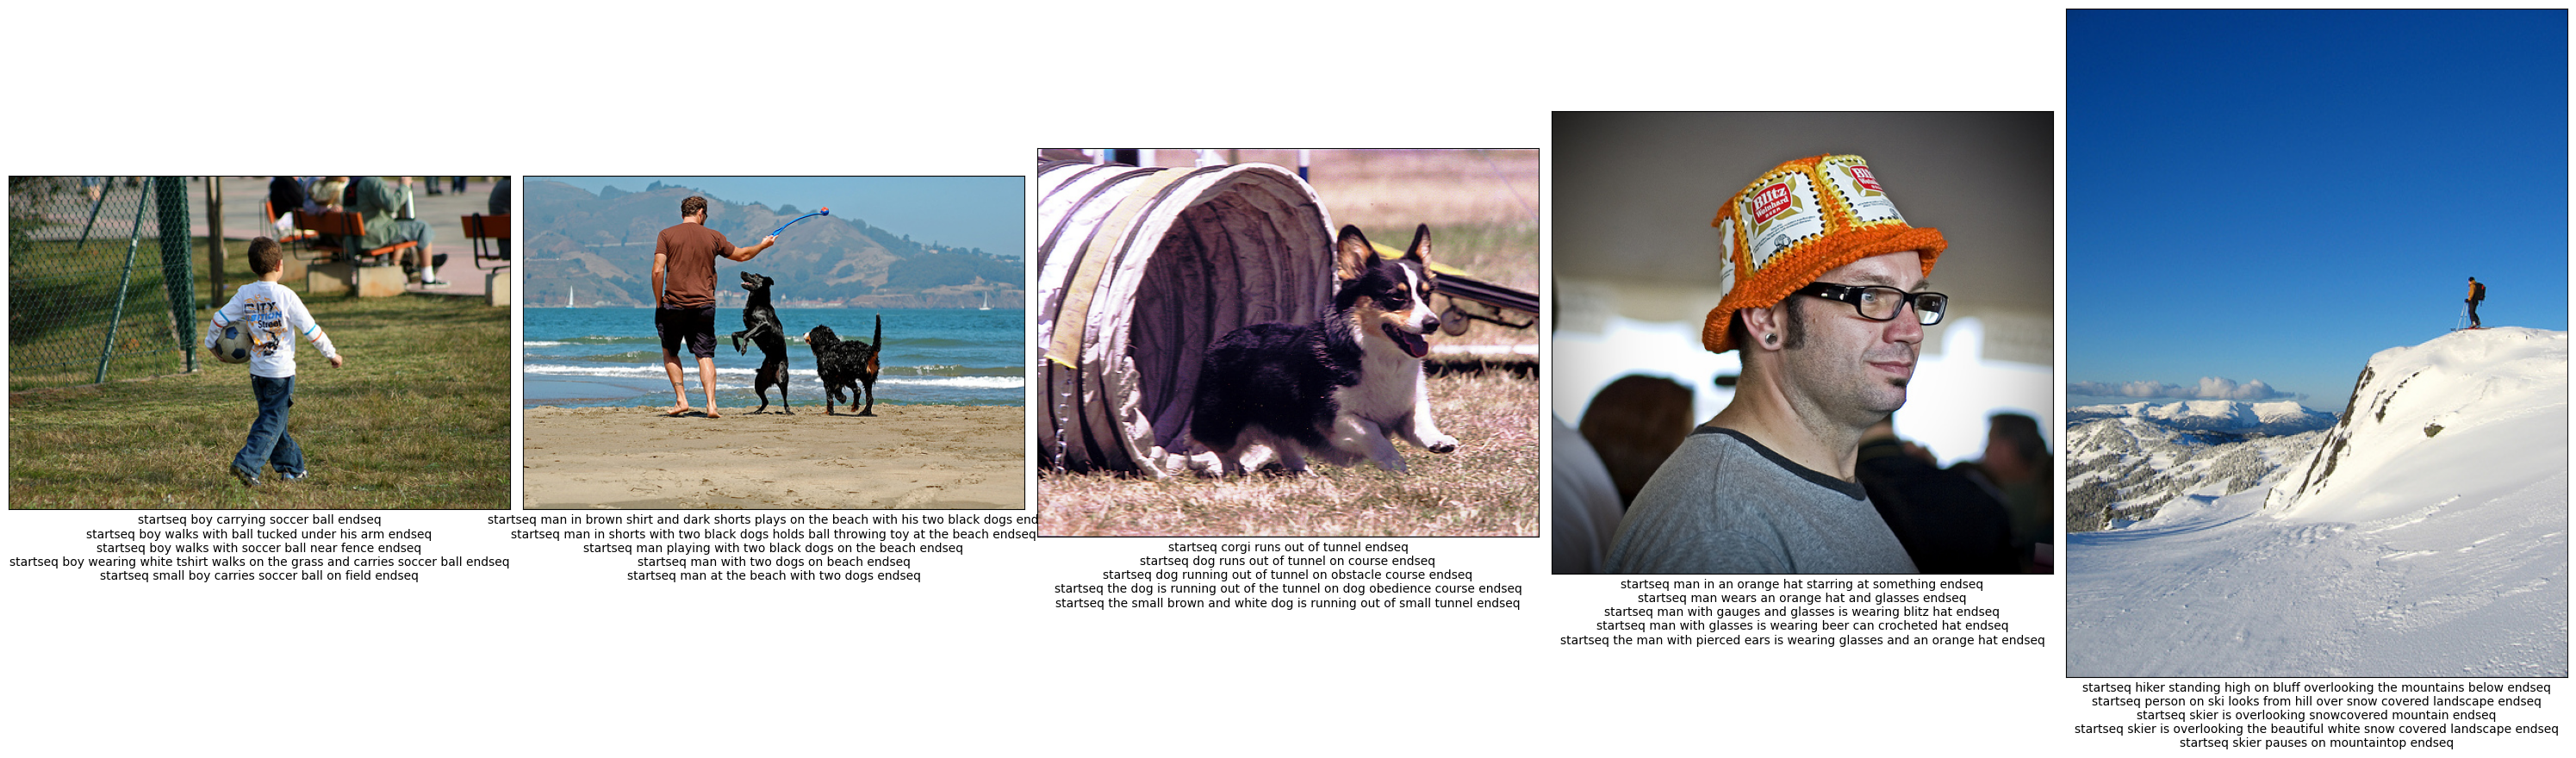

In [6]:
def plot_images_with_captions(image_paths, captions_dict, sample_size=5):
    sample_images = random.sample(list(image_paths), sample_size)
    
    plt.figure(figsize=(30, 20))
    for i, image_path in enumerate(sample_images):
        img = plt.imread(os.path.join(images_path, image_path))
        plt.subplot(sample_size//5 + 1, 5, i+1)
        plt.imshow(img)
        plt.xlabel('\n'.join(captions_dict[image_path]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

image_paths = list(captions_dict.keys())[:100]  # Limiting to first 100 for quick visualization
plot_images_with_captions(image_paths, captions_dict)

In [7]:
len(all_captions)

40455

## Data Preprocessing

Preprocessing will involve extracting features from images using a pre-trained VGG16 model (with the final classification layer removed) and preparing the text data through tokenization, cleaning, and encoding.

In [8]:
# Gather all unique image names
all_images = list(captions_dict.keys())

# Shuffle the list to ensure random distribution
np.random.shuffle(all_images)

# Calculate split sizes
train_size = int(len(all_images) * 0.8)
val_size = int(len(all_images) * 0.1)

# Split the data
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]

print(f"Total images: {len(all_images)}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Testing images: {len(test_images)}")

Total images: 8091
Training images: 6472
Validation images: 809
Testing images: 810


In [9]:
train_captions_list = [caption for img_name in train_images for caption in captions_dict[img_name]]


### Tokenization of Captions
- A `Tokenizer` from Keras is initialized and fitted on the list of training captions, `train_captions_list`.
- The vocabulary size (`vocab_size`) is determined by adding 1 to the total number of unique words found in the captions.
- The maximum sequence length (`max_length`) for the captions is calculated based on the longest caption in the training set.

### Data Augmentation Strategy
- A sequential data augmentation pipeline is defined using TensorFlow Keras, including:
  - Horizontal flips, considered generally safe for natural images.
  - Moderate rotations of 0.2 radians.
  - Random zooming by 20% both vertically and horizontally.
  - Slight translations in both height and width by 10%.
  - Minor contrast adjustments to slightly alter image contrast.

### Feature Extraction with VGG16
- The VGG16 model pre-trained on ImageNet is loaded with its fully connected layers (`include_top=True`).
- A new model is created to output features from the second-to-last fully connected layer (`fc2`), which contains 4096 units, for the purpose of capturing rich image representations.

### Preprocessing and Encoding Function
- A function `preprocess_and_encode_image` is defined to:
  - Preprocess input images by resizing them to 224x224 pixels, converting them to arrays, and applying VGG16-specific preprocessing.
  - Optionally apply the defined data augmentation strategies to the images if `apply_augmentation` is set to `True`, intended for use during training to introduce variability and improve model robustness.
  - Extract and return features from the processed (and optionally augmented) images using the modified VGG16 model that outputs from the `fc2` layer.

In [10]:
# Tokenize the TRAIN captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_captions_list)
vocab_size = len(tokenizer.word_index) + 1

# Max sequence length using TRAIN captions
max_length = max(len(c.split()) for c in train_captions_list)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Flipping horizontally is generally safe for natural images
    tf.keras.layers.RandomRotation(0.2),  # A moderate rotation
    tf.keras.layers.RandomZoom(0.2, 0.2),  # Randomly zooming inside the pictures
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Slight translation
    tf.keras.layers.RandomContrast(0.1),  # Slightly altering contrast
])

# Load the VGG16 model including the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=True)

# Create a new model that outputs the features from the second-to-last fully connected layer
# The second-to-last dense layer has 4096 units
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Function to preprocess images and extract features
def preprocess_and_encode_image(image_path, apply_augmentation = False):
    # Preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # Apply data augmentation
    # Optionally apply data augmentation if specified (e.g., during training)
    if apply_augmentation:
        image = data_augmentation(image)
    # Encode the image using the modified VGG16 model
    features = model.predict(image)
    
    return features

In [11]:
def preprocess_images_for_split(image_names, apply_augmentation = False):

    images_features = {}
    for img_name in image_names:
        image_path = os.path.join(images_path, img_name)
        image = preprocess_and_encode_image(image_path, apply_augmentation)
        images_features[img_name] = image
    return images_features

In [12]:
train_images_features = preprocess_images_for_split(train_images, False)
print("Training images preprocessed:", len(train_images_features))

val_images_features = preprocess_images_for_split(val_images)
print("Validation images preprocessed:", len(val_images_features))

test_images_features = preprocess_images_for_split(test_images)
print("Test images preprocessed:", len(test_images_features))

1/1 [==============================] - 0s 17ms/step
Training images preprocessed: 6472
1/1 [==============================] - 0s 17ms/step
Validation images preprocessed: 809
1/1 [==============================] - 0s 21ms/step
Test images preprocessed: 810


In [13]:
# These should contain the filenames of images assigned to each set

def split_data(captions_dict, images_features, image_list):
    captions_split = {img_name: captions_dict[img_name] for img_name in image_list if img_name in captions_dict}
    features_split = {img_name: images_features[img_name] for img_name in image_list if img_name in images_features}
    return captions_split, features_split

# Split the data
train_captions, train_features = split_data(captions_dict, train_images_features, train_images)
val_captions, val_features = split_data(captions_dict, val_images_features, val_images)
test_captions, test_features = split_data(captions_dict, test_images_features, test_images)

In [14]:
def data_generator(captions_dict, image_features, tokenizer, max_length, vocab_size):
    while True:  # Loop forever so the generator never terminates
        for img_name, captions in captions_dict.items():
            # Retrieve the image feature
            img_feature = image_features.get(img_name)
            if img_feature is None:
                continue  # Skip images without features
            img_feature = np.squeeze(img_feature)  # Ensure img_feature is of shape (4096,)
            for caption in captions:
                # Tokenize the caption
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # Split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Yield the data in the correct structure
                    yield {'input_1': img_feature, 'input_2': in_seq}, out_seq

In [15]:
train_captions

{'3326454455_960e5442e9.jpg': ['startseq male soccer player wearing red uniform jumping in the air and pulling up his shorts endseq',
  'startseq soccer player pulls his shorts up endseq',
  'startseq soccer player wearing red costume makes an obscene gesture endseq',
  'startseq man in red sports uniform and blue shoes jumping and pull up legs of shorts endseq',
  'startseq we can see the white underwear of the man wearing the red soccer jersey because he is pulling up his shorts endseq'],
 '3613030730_0b28b079ba.jpg': ['startseq baby reaches for water dropping endseq',
  'startseq small boy in the bath covered in soap suds endseq',
  'startseq young toddler plays in the bathtub with bubbles and suds endseq',
  'startseq the smiling child has bubbles near their ear endseq',
  'startseq the toddler is splashing water in the tub with suds all over endseq'],
 '3643087589_627a0a9e01.jpg': ['startseq large yellow dog and small white dog in the grass endseq',
  'startseq small light tan dog

In [16]:
from tensorflow.keras.utils import Sequence

batch_size = 64

# Create the TensorFlow dataset from the generator
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, train_features, tokenizer, max_length, vocab_size),
    output_types=({'input_1': tf.float32, 'input_2': tf.int32}, tf.float32),
    output_shapes=({'input_1': (4096,), 'input_2': (max_length,)}, (vocab_size,))
)

# Prepare the dataset for training by batching, shuffling, etc.
dataset = dataset.batch(batch_size).shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, val_features, tokenizer, max_length, vocab_size),
    output_types=({'input_1': tf.float32, 'input_2': tf.int32}, tf.float32),
    output_shapes=({'input_1': (4096,), 'input_2': (max_length,)}, (vocab_size,))
)

validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Model Architecture

The proposed system will incorporate a merge model architecture that combines preprocessed image features and text data. This architecture includes:

Text Processor: An LSTM-based model for processing captions.
Decoder: A merge model that combines features and processed text to generate captions. This model will include dense layers and dropout for regularization to mitigate overfitting.

In [17]:
input_img_features = Input(shape=(4096,), name='input_1')
input_captions = Input(shape=(max_length,), name='input_2')

# Process image features
img_features_layer = Dense(256, activation='relu')(input_img_features)
img_features_layer = Dropout(0.5)(img_features_layer)

# Process text sequences
text_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input_captions)
text_lstm = LSTM(256)(text_embedding)
text_lstm = Dropout(0.5)(text_lstm)

# Combine the outputs from the image features and text processing paths
decoder_output = Add()([img_features_layer, text_lstm])
decoder_output = Dense(256, activation='relu')(decoder_output)

# Output layer for word prediction
output = Dense(vocab_size, activation='softmax')(decoder_output)

# Define the model
decoder_model = Model(inputs=[input_img_features, input_captions], outputs=output)

# Compile the model
decoder_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Display the model summary
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 256)      1993984     ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          1048832     ['input_1[0][0]']                
                                                                                            

## Model Training & Evaluation

Given the limited memory resources, the training process will utilize a technique known as "Progressive Loading" to manage memory usage efficiently. This approach involves loading batches of data progressively during training to avoid overwhelming the system's memory. The model will be trained using the Adam optimizer, with a focus on minimizing categorical cross-entropy loss.

The model's performance will be evaluated using the BLEU score, a standard metric for assessing the quality of text generated by machine learning models. This evaluation will help in determining the effectiveness of the model in generating coherent and relevant captions for images.

In [18]:
class BLEUScoreCallback(Callback):
    def __init__(self, dataset, model, tokenizer, max_length):
        super(BLEUScoreCallback, self).__init__()
        self.dataset = dataset
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length

    def on_epoch_end(self, epoch, logs=None):
        actual, predicted = list(), list()
        # Loop over the dataset and generate predictions
        for inputs, targets in self.dataset:
            yhat = self.model.predict(inputs['input_1'])
            
            # Convert prediction into text
            predicted_caption = self.predict_sequence(yhat)
            
            # Extract actual caption from targets
            actual_caption = self.targets_to_text(targets)
            
            predicted.append(predicted_caption)
            actual.append([actual_caption])
            
        # Calculate BLEU score
        score = corpus_bleu(actual, predicted)
        print(f'\nEpoch {epoch+1} BLEU score: {score}')
    
    def predict_sequence(self, yhat):
        """Converts a sequence of probabilities (yhat) into a caption, stopping at 'endseq'."""
        sequence = np.argmax(yhat, axis=-1)
        caption = []
        for i in sequence:
            if i == 0:  # Skip padding tokens or undefined (if using 0 as a placeholder)
                continue
            word = self.tokenizer.index_word.get(i, None)
            if word == 'endseq':
                break  # Stop if 'endseq' is encountered
            if word is not None and word != 'startseq':  # Skip 'startseq'
                caption.append(word)
        return ' '.join(caption)
    
    def targets_to_text(self, targets):
        """Extracts the actual caption from the target data, ignoring 'startseq' and 'endseq'."""
        caption = []
        for i in targets:
            word = self.tokenizer.index_word.get(i, None)
            if word == 'endseq' or word == 'startseq' or word is None:
                continue 
            caption.append(word)
        return ' '.join(caption)

In [19]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K


class LossThresholdCallback(Callback):
    def __init__(self, threshold):
        super(LossThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if train_loss is not None:
            print(f"Batch {batch}: Training loss: {train_loss}")
            if train_loss < self.threshold:
                print(f'\nStopping training because training loss {train_loss} has reached below the threshold {self.threshold}')
                self.model.stop_training = True
            if val_loss is not None:
                if val_loss < self.threshold:
                    print(f'\nStopping training because validation loss has reached below {self.threshold}')
                    self.model.stop_training = True

# Due to lack of GPUs we set 1 epoch with larger loss threshold
loss_threshold = 5
epochs = 1

bleu_callback = BLEUScoreCallback(validation_dataset, decoder_model, tokenizer, max_length)
loss_threshold_callback = LossThresholdCallback(threshold=loss_threshold)

# Fit the model with the custom loss threshold callback
history = decoder_model.fit(
    dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[bleu_callback, loss_threshold_callback],
    verbose=1
)

Batch 0: Training loss: 8.906129837036133
      1/Unknown - 16s 16s/step - loss: 8.9061Batch 1: Training loss: 8.887807846069336
      2/Unknown - 16s 82ms/step - loss: 8.8878Batch 2: Training loss: 8.734282493591309
      3/Unknown - 16s 78ms/step - loss: 8.7343Batch 3: Training loss: 8.608379364013672
      4/Unknown - 16s 78ms/step - loss: 8.6084Batch 4: Training loss: 8.503186225891113
      5/Unknown - 16s 78ms/step - loss: 8.5032Batch 5: Training loss: 8.37158489227295
      6/Unknown - 16s 77ms/step - loss: 8.3716Batch 6: Training loss: 8.27517318725586
      7/Unknown - 16s 77ms/step - loss: 8.2752Batch 7: Training loss: 8.123226165771484
      8/Unknown - 16s 78ms/step - loss: 8.1232Batch 8: Training loss: 7.943797588348389
      9/Unknown - 16s 79ms/step - loss: 7.9438Batch 9: Training loss: 7.764975070953369
     10/Unknown - 17s 78ms/step - loss: 7.7650Batch 10: Training loss: 7.715374946594238
     11/Unknown - 17s 78ms/step - loss: 7.7154Batch 11: Training loss: 7.6116161

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Left to test

## Conclusion

Throughout this project, we embarked on the challenging yet fascinating journey of building an efficient image captioning system leveraging deep neural networks. Starting with the foundational steps of tokenizing the captions and establishing a robust data augmentation strategy, we aimed to enhance the model's ability to generalize from the training data to unseen images effectively.

### Key Components of the Project:

- **Tokenization and Vocabulary Construction**: We utilized the Keras `Tokenizer` to process our training captions, constructing a vocabulary that captures the diversity of linguistic expressions in the dataset. This vocabulary served as the basis for converting text data into sequences that the model can learn from.

- **Data Augmentation**: Recognizing the importance of variability in training data for improving model robustness, we implemented a comprehensive data augmentation pipeline. This pipeline includes horizontal flipping, moderate rotation, random zooming, slight translation, and contrast adjustment, intending to mimic the vast array of visual perspectives encountered in the real world.

- **Feature Extraction with VGG16**: Leveraging the power of the VGG16 architecture, we extracted rich feature representations of images. By modifying the VGG16 model to output features from its second-to-last fully connected layer, we prepared a foundation for the model to learn the intricate associations between visual elements and their linguistic descriptors.

- **Model Training and Evaluation**: Through the iterative process of model training, we meticulously tuned our approach, balancing the computational demands with the quest for accuracy. We introduced a custom callback to calculate BLEU scores at the end of each training epoch, providing a quantitative measure of the model's captioning performance.

- **Challenges and Learnings**: Throughout the project, we navigated various challenges, including managing computational resources, addressing overfitting through data augmentation, and fine-tuning the model to improve caption quality. These challenges offered valuable insights into the complexities of deep learning applications in natural language processing and computer vision.

### Future Directions:

Moving forward, there are several avenues for enhancing the image captioning system, including experimenting with different neural network architectures, exploring more advanced data augmentation techniques, and incorporating attention mechanisms to refine the model's focus on relevant image regions.

### Research Paper:

This project draws inspiration and technical insight from a wide array of sources, including the foundational research paper which can be accessed here: [Efficient Image Captioning using Deep Neural Networks](https://arxiv.org/ftp/arxiv/papers/2009/2009.02565.pdf). This paper provides a deeper understanding of the methodologies and theoretical underpinnings that have informed our approach, offering a comprehensive overview of the state-of-the-art in image captioning.